<a href="https://colab.research.google.com/github/eluo28/DetectMySetup/blob/master/DetectMySetup_(clean).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a computer setup detection application with Detectron2.

with the help of [this tutorial on replicating Airbnb's Amenity Detection](https://github.com/mrdbourke/airbnb-amenity-detection/)

This application uses an object detection model to outline and classify common amenities in a computer setup.

Purpose? to learn more about the implementation and deployment of machine learning models.

# Installations + imports



In [1]:
# Install Detectron2 dependencies: https://detectron2.readthedocs.io/tutorials/install.html (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import torch, torchvision

# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 66.8MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 276kB 5.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=2650c255f3fbef917bf17cd846d32e700ab9a6b730da30f686c9b4677d6c4c5f
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.7MB 5.4MB/s 
     |████████████████████████████████| 2.2MB 8.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=4423280667b4a6a03773d38e79f330d11919bba7f761aae1886152f294fc512e
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp36-cp36m-linux_x86_64.whl size=266512 sha256=5d2e5b93a01f0d137707e307e4015b40268ad9833670e339643a17fefcdc2099
  Stored in directory: /root/.cache/pip/wheels/86/19/08/49b25f258ead1f861c9ab2fc41f73636f2928859adbb0e9797
Successfully built fvcore pycocotools
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully unins

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import random
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode
import json
import pprint

import logging
import os
import argparse
from collections import OrderedDict

# import some common detectron2 utilities
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_test_loader
)

from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image


# Training Custom Model

1. Download data (images) & label files from Open Images
2. Format the data (images) & label files to be compatiable with Detectron2
3. Download a pretrained Detectron2 model and update it (train it) with our own data
4. Verify the updated model works on our own images by making predictions
5. Evaluate the model using a validation/test set and Detectron2 evaluators

#Download data

In [2]:
#download label files

# Training bounding boxes (1.11G)
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

# Validating bounding boxes (23.94M)
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
    
# Testing bounding boxes (73.89M)
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

# Class names of images (11.73K)
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2020-08-02 19:10:15--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G   123MB/s    in 9.3s    

2020-08-02 19:10:24 (123 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2020-08-02 19:10:25--  https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25105048 (24M) [text/c

In [3]:
#Download training data from GCP
#I already uploaded folder of images to GCP from local storage after downloading from open images using downloadIO.py
!gsutil -m cp -r gs://detectmysetup/train sample_data
!gsutil -m cp -r gs://detectmysetup/validation sample_data

Streaming output truncated to the last 5000 lines.
Copying gs://detectmysetup/train/1c387e8561b912dd.jpg...
Copying gs://detectmysetup/train/1c41850774f6539b.jpg...
Copying gs://detectmysetup/train/1c42cd7c522ca8e3.jpg...
Copying gs://detectmysetup/train/1c44214a0af82eed.jpg...
Copying gs://detectmysetup/train/1c47e08aaf93ba5b.jpg...
Copying gs://detectmysetup/train/1c4d9fcf288781b9.jpg...
Copying gs://detectmysetup/train/1c5355bfbace046b.jpg...
Copying gs://detectmysetup/train/1c5bde716ab03754.jpg...
Copying gs://detectmysetup/train/1c5c239b4c4ff9ba.jpg...
Copying gs://detectmysetup/train/1c6c7fc58d40ed64.jpg...
Copying gs://detectmysetup/train/1c6d3da0629ce39f.jpg...
Copying gs://detectmysetup/train/1c7348c293a885f7.jpg...
Copying gs://detectmysetup/train/1c71b8ac0b2b7c3f.jpg...
Copying gs://detectmysetup/train/1c73e2db47b4c4e5.jpg...
Copying gs://detectmysetup/train/1c78c0874960008e.jpg...
Copying gs://detectmysetup/train/1c7ca4b0dd63fb42.jpg...
Copying gs://detectmysetup/train/1c7f

#Preprocess Data

In [4]:
# Setup the paths for the training and validation data
train_path = "./sample_data/train/"
valid_path = "./sample_data/validation/"

In [5]:
# Define the target classes (sort in alphabetical so labels align later on)
subset_classes = ["Computer keyboard","Computer monitor","Computer mouse","Lamp","Laptop","Microphone"]

In [6]:
def get_image_ids(image_folder=None):
    """
    Explores a folder of images and gets their ID from their file name.
    Returns a list of all image ID's in image_folder.
    E.g. image_folder/608fda8c976e0ac.jpg -> ["608fda8c976e0ac"]
    
    Params
    ------
    image_folder (str): path to folder of images, e.g. "../validation/"
    """
    return [os.path.splitext(img_name)[0] for img_name in os.listdir(image_folder) if img_name.endswith(".jpg")]

In [7]:
# Make a function which formats a specific annotations csv based on what we're dealing with
def format_annotations(image_folder, annotation_file, target_classes=None):
    """
    Formats annotation_file based on images contained in image_folder.
    Will get all unique image IDs and make sure annotation_file
    only contains those (the target images).
    Adds meta-data to annotation_file such as class names and categories.
    If target_classes isn't None, the returned annotations will be filtered by this list.
    Note: image_folder and annotation_file should both be validation if working on
    validation set or both be training if working on training set.
    
    Params
    ------
    image_folder (str): path to folder of target images.
    annotation_file (str): path to annotation file of target images.
    target_classes (list), optional: a list of target classes you'd like to filter labels.
    """
    # Get all image ids from target directory
    image_ids = get_image_ids(image_folder)
    
    # Setup annotation file and classnames
    annot_file = pd.read_csv(annotation_file)
 
    classes = pd.read_csv("class-descriptions-boxable.csv",
                          names=["LabelName", "ClassName"])

    # Create classname column on annotations which converts label codes to string labels
    annot_file["ClassName"] = annot_file["LabelName"].map(classes.set_index("LabelName")["ClassName"])
    
    new = annot_file["ImageID"].isin(image_ids)

    # Sort annot_file by "ClassName" for alphabetical labels (used with target_classes)
    annot_file.sort_values(by=["ClassName"], inplace=True)
  
    # Make sure we only get the images we're concerned about
    if target_classes:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids) & annot_file["ClassName"].isin(target_classes)]
    else:
        annot_file = annot_file[annot_file["ImageID"].isin(image_ids)]

    assert len(annot_file.ImageID.unique()) == len(image_ids), "Label unique ImageIDs doesn't match target folder."

    # Add ClassID column, e.g. "Laptop, Lamp" -> 1, 2
    annot_file["ClassName"] = pd.Categorical(annot_file["ClassName"])
    annot_file["ClassID"] = annot_file["ClassName"].cat.codes
    
    return annot_file

In [8]:
def rel_to_absolute(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Params
    ------
    bbox (array): relative dimensions of bounding box in format (x0, y0, x1, y1 or Xmin, Ymin, Xmax, Ymax)
    height (int): height of image
    width (int): width of image
    """
    bbox[0] = np.round(np.multiply(bbox[0], width)) # x0
    bbox[1] = np.round(np.multiply(bbox[1], height)) # y0
    bbox[2] = np.round(np.multiply(bbox[2], width)) # x1
    bbox[3] = np.round(np.multiply(bbox[3], height)) # y1
    return [i.astype("object") for i in bbox] # convert all to objects for JSON saving

In [9]:
def get_image_dicts(image_folder, annotation_file, target_classes=None):
    """
    Create Dectectron2 style labels in the form of a list of dictionaries.
    
    Params
    ------
    image_folder (str): target folder containing images
    annotations (DataFrame): DataFrame of image label data
    target_classes (list): names of target Open Images classes

    Note: image_folder and annotation_file should both relate to the same dataset (this could be improved).
    E.g.
    image_folder = valid_images & annotation_file = valid_annotations (both are for the validation set)
    """
    # Get name of dataset from image_folder 
    dataset_name = str(image_folder)

    # Create dataset specific annotations.
    annotations = format_annotations(image_folder=image_folder, 
                                     annotation_file=annotation_file,
                                     target_classes=target_classes)

    # Get all unique image ids from target folder
    img_ids = get_image_ids(image_folder)

    # Add some verbosity 
    print(f"\nUsing {annotation_file} for annotations...")
    print(f"On dataset: {dataset_name}")
    print("Classes we're using:\n{}".format(annotations["ClassName"].value_counts()))
    print(f"Total number of images: {len(img_ids)}")
    
    # Start creating image dictionaries (Detectron2 style labelling)
    img_dicts = []
    for idx, img in tqdm(enumerate(img_ids)):
        record = {}
        
        # Get image metadata
        file_name = image_folder + img + ".jpg"
        height, width = cv2.imread(file_name).shape[:2]
        img_data = annotations[annotations["ImageID"] == img].reset_index() # reset_index(): important for images
                                                                            # with multiple objects

        # Update record dictionary
        record["file_name"] = file_name
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        # Create list of image annotations (labels)
        img_annotations = []
        for i in range(len(img_data)): # this is where we loop through examples with multiple objects in an image
            category_id = img_data.loc[i]["ClassID"].astype("object") # JSON (for evalution) can't take int8 (NumPy type) must be native Python type
            # Get bounding box coordinates in Detectron2 style (x0, y0, x1, y1)
            bbox = np.float32(img_data.loc[i][["XMin", "YMin", "XMax", "YMax"]].values)
            # Convert bbox from relative to absolute pixel dimensions
            bbox = rel_to_absolute(bbox=bbox, height=height, width=width)
            # Setup annot (1 annot = 1 label, there might be more) dictionary
            annot = {
                "bbox": bbox, 
                "bbox_mode": BoxMode.XYXY_ABS, # See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode.XYXY_ABS
                "category_id": category_id
            }
            img_annotations.append(annot)
            
        # Update record dictionary with annotations
        record["annotations"] = img_annotations
        
        # Add record dictionary with image annotations to img_dicts list
        img_dicts.append(record)

    # Save img_dicts to JSON for use later
    prefix = "valid" if "valid" in image_folder else "train"
    json_file = os.path.join(image_folder, prefix + "_labels.json")
    print(f"\nSaving labels to: {json_file}...")
    with open(json_file, "w") as f:
      json.dump(img_dicts, f)

    print("Showing an example:")
    pprint.pprint(random.sample(img_dicts, 1))

    # return img labels dictionary
    return img_dicts

In [10]:
# Create list of validation image dictionaries
%%time
val_img_dicts = get_image_dicts(image_folder=valid_path,
                                annotation_file="validation-annotations-bbox.csv",
                                target_classes=subset_classes)

5it [00:00, 46.30it/s]


Using validation-annotations-bbox.csv for annotations...
On dataset: ./sample_data/validation/
Classes we're using:
Microphone           140
Computer monitor     100
Lamp                  79
Laptop                70
Computer keyboard     67
Computer mouse        24
Name: ClassName, dtype: int64
Total number of images: 301


301it [00:04, 60.94it/s]


Saving labels to: ./sample_data/validation/valid_labels.json...
Showing an example:
[{'annotations': [{'bbox': [864.0, 350.0, 1024.0, 523.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [998.0, 2.0, 1024.0, 128.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [853.0, 150.0, 957.0, 280.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [850.0, 2.0, 954.0, 94.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [888.0, 205.0, 981.0, 301.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [755.0, 358.0, 867.0, 451.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  

In [11]:
# Create list of training image dictionaries
%%time
train_img_dicts = get_image_dicts(image_folder=train_path,
                                  annotation_file="train-annotations-bbox.csv",
                                  target_classes=subset_classes)

7it [00:00, 58.23it/s]


Using train-annotations-bbox.csv for annotations...
On dataset: ./sample_data/train/
Classes we're using:
Lamp                 3663
Laptop               3361
Computer keyboard    1958
Computer monitor     1690
Microphone           1545
Computer mouse        733
Name: ClassName, dtype: int64
Total number of images: 6453


6453it [02:03, 52.39it/s]



Saving labels to: ./sample_data/train/train_labels.json...
Showing an example:
[{'annotations': [{'bbox': [844.0, 195.0, 1023.0, 655.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3},
                  {'bbox': [0.0, 87.0, 226.0, 727.0],
                   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
                   'category_id': 3}],
  'file_name': './sample_data/train/015c813d19448db9.jpg',
  'height': 1024,
  'image_id': 1583,
  'width': 1024}]
CPU times: user 2min 35s, sys: 6.01 s, total: 2min 41s
Wall time: 2min 41s


In [12]:
def load_json_labels(image_folder):
    """
    Returns Detectron2 style labels of images (list of dictionaries) in image_folder based on JSON label file in image_folder.

    Note: Requires JSON label to be in image_folder. See get_image_dicts(). 
    
    Params
    ------
    image_folder (str): target folder containing images
    """
    # Get absolute path of JSON label file
    for file in os.listdir(image_folder):
      if file.endswith(".json"):
        json_file = os.path.join(image_folder, file)

    # Check to see if json_file exists 
    assert json_file, "No .json label file found, please make one with get_image_dicts()"

    with open(json_file, "r") as f:
      img_dicts = json.load(f)

    # Convert bbox_mode to Enum of BoxMode.XYXY_ABS (doesn't work loading normal from JSON)
    for img_dict in img_dicts:
      for annot in img_dict["annotations"]:
        annot["bbox_mode"] = BoxMode.XYXY_ABS

    return img_dicts

#Register custom data

In [13]:
# Loop through different datasets
for dataset in ["train", "valid"]:
  
     # Create dataset name strings
     if dataset=="train":
       dataset_name= train_path
     elif dataset=="valid":
       dataset_name= valid_path

     print(f"Registering {dataset_name}")

     # Register the datasets with Detectron2's DatasetCatalog, which has space for a lambda function to preprocess it
     DatasetCatalog.register(dataset_name, lambda dataset_name=dataset_name: load_json_labels(dataset_name))

     # Create the metadata for our dataset (the main thing being the classnames we're using)
     MetadataCatalog.get(dataset_name).set(thing_classes=subset_classes)

# Setup metadata variable
metadata = MetadataCatalog.get(train_path)

Registering ./sample_data/train/
Registering ./sample_data/validation/


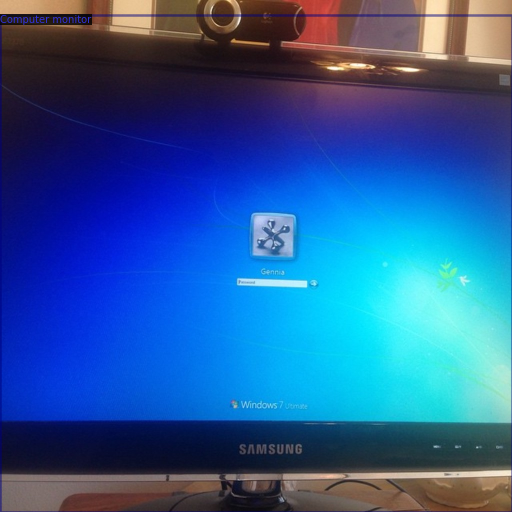

In [14]:
#check works
for label in random.sample(val_img_dicts, 1):
    img = cv2.imread(label["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], # revervse the image pixel order (BGR -> RGB)
                            metadata=metadata, # use the metadata variable we created about
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(label)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#Training the model

In [15]:
# Setup a model config (recipe for training a Detectron2 model)
cfg=get_cfg()

# Add some basic instructions for the Detectron2 model from the model_zoo: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_101_FPN_3x.yaml'))

# Add some pretrained model weights from an object detection model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/retinanet_R_101_FPN_3x.yaml')

# Setup datasets to train/validate on (this will only work if the datasets are registered with DatasetCatalog)
cfg.DATASETS.TRAIN = (train_path,)
cfg.DATASETS.TEST = (valid_path,)

# How many dataloaders to use? This is the number of CPUs to load the data into Detectron2, Colab has 2, so we'll use 2
cfg.DATALOADER.NUM_WORKERS = 2

# How many images per batch? The original models were trained on 8 GPUs with 16 images per batch, since we have 1 GPU: 16/8 = 2.
cfg.SOLVER.IMS_PER_BATCH = 2

# We do the same calculation with the learning rate as the GPUs, the original model used 0.01.
cfg.SOLVER.BASE_LR = 0.0002

# How many iterations are we going for?
cfg.SOLVER.MAX_ITER = 5000

# ROI = region of interest, as in, how many parts of an image are interesting, how many of these are we going to find? 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256

# number of classes we dealing with
cfg.MODEL.RETINANET.NUM_CLASSES = 6

# Setup output directory, all the model artefacts will get stored here in a folder called "outputs" 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Setup the default Detectron2 trainer, see: https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer
trainer = DefaultTrainer(cfg)

# Resume training from model checkpoint or not, we're going to just load the model in the config: https://detectron2.readthedocs.io/modules/engine.html#detectron2.engine.defaults.DefaultTrainer.resume_or_load
trainer.resume_or_load(resume=False) 

# Start training
trainer.train()

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[08/02 19:17:30 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:03, 71.9MB/s]                           
Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (54, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (54,) in the model! You might want to double check if this is expected.


[08/02 19:17:37 d2.engine.train_loop]: Starting training from iteration 0
[08/02 19:17:50 d2.utils.events]:  eta: 0:48:12  iter: 19  total_loss: 1.292  loss_cls: 1.018  loss_box_reg: 0.282  time: 0.5840  data_time: 0.0214  lr: 0.000004  max_mem: 3097M
[08/02 19:18:02 d2.utils.events]:  eta: 0:49:13  iter: 39  total_loss: 0.892  loss_cls: 0.784  loss_box_reg: 0.222  time: 0.5855  data_time: 0.0068  lr: 0.000008  max_mem: 3097M
[08/02 19:18:14 d2.utils.events]:  eta: 0:49:01  iter: 59  total_loss: 0.947  loss_cls: 0.784  loss_box_reg: 0.227  time: 0.5930  data_time: 0.0050  lr: 0.000012  max_mem: 3252M
[08/02 19:18:27 d2.utils.events]:  eta: 0:49:29  iter: 79  total_loss: 1.317  loss_cls: 1.043  loss_box_reg: 0.313  time: 0.6026  data_time: 0.0064  lr: 0.000016  max_mem: 3252M
[08/02 19:18:40 d2.utils.events]:  eta: 0:49:57  iter: 99  total_loss: 1.064  loss_cls: 0.878  loss_box_reg: 0.239  time: 0.6133  data_time: 0.0057  lr: 0.000020  max_mem: 3252M
[08/02 19:18:53 d2.utils.events]:  e

#Evaluate


In [16]:
# Setup an evaluator, we use COCO because it's one of the standards for object detection: https://detectron2.readthedocs.io/modules/evaluation.html#detectron2.evaluation.COCOEvaluator
evaluator = COCOEvaluator(dataset_name=valid_path, 
                          cfg=cfg, 
                          distributed=False, # use multiple GPUs? we're in Colab so we only use one
                          output_dir="./output/")

# Create a dataloader to load in the test data 
val_loader = build_detection_test_loader(cfg, 
                                         dataset_name=valid_path)

# Make inference on the validation dataset: https://detectron2.readthedocs.io/tutorials/evaluation.html
inference_on_dataset(model=trainer.model, # get the model from the trainer
                     data_loader=val_loader, 
                     evaluator=evaluator)

[08/02 20:15:06 d2.evaluation.coco_evaluation]: './sample_data/validation/' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/02 20:15:06 d2.data.datasets.coco]: Converting annotations of dataset './sample_data/validation/' to COCO format ...)
[08/02 20:15:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/02 20:15:06 d2.data.datasets.coco]: Conversion finished, #images: 301, #annotations: 480
[08/02 20:15:06 d2.data.datasets.coco]: Caching COCO format annotations at './output/./sample_data/validation/_coco_format.json' ...
[08/02 20:15:06 d2.data.common]: Serializing 301 elements to byte tensors and concatenating them all ...
[08/02 20:15:06 d2.data.common]: Serialized dataset takes 0.08 MiB
[08/02 20:15:06 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/02 20:15:06 d2.evaluation.evaluator]: Start inference on 3

OrderedDict([('bbox',
              {'AP': 53.953950383914275,
               'AP-Computer keyboard': 59.83021014267847,
               'AP-Computer monitor': 56.59847659877494,
               'AP-Computer mouse': 75.69945752296104,
               'AP-Lamp': 41.12565200956107,
               'AP-Laptop': 57.01031685212534,
               'AP-Microphone': 33.459589177384785,
               'AP50': 72.02538074940286,
               'AP75': 58.283484348824175,
               'APl': 57.66629564680487,
               'APm': 15.556008294289356,
               'APs': 0.1667371984765129})])

In [17]:
# Save config to file
with open("output/config.yaml", "w") as f:
    f.write(cfg.dump())

#Predictions


In [27]:
# Make a prediction and display inferences
def make_inference(image, model_config, model_weights, threshold=0.2, n=10):
  """
  Makes inference on image (single image) using model_config, model_weights and threshold.

  Returns image with n instance predictions drawn on.

  Params:
  -------
  image (str) : file path to target image
  model_config (str) : file path to model config in .yaml format
  model_weights (str) : file path to model weights 
  threshold (float) : confidence threshold for model prediction, default 0.5
  n (int) : number of prediction instances to draw on, default 5
    Note: some images may not have 5 instances to draw on depending on threshold,
    n=5 means the top 5 instances above the threshold will be drawn on.
  save (bool) : if True will save image with predicted instances to file, default False
  """

  # Setup config
  cfg = get_cfg()
  cfg.merge_from_file(model_config)
  cfg.MODEL.WEIGHTS = model_weights
  cfg.MODEL.RETINANET.SCORE_THRESH_TEST = threshold

  
  # Setup predictor
  predictor = DefaultPredictor(cfg)
  img = cv2.imread(image)


  visualizer = Visualizer(img_rgb=img[:, :, ::-1],
                          metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]).set(thing_classes=subset_classes),
                          scale=0.7)
  
  outputs = predictor(img) # Outputs: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances
  
  # Draw on predictions to image
  visualizer = visualizer.draw_instance_predictions(outputs["instances"][:n].to("cpu"))
  cv2_imshow(visualizer.get_image()[:, :, ::-1])

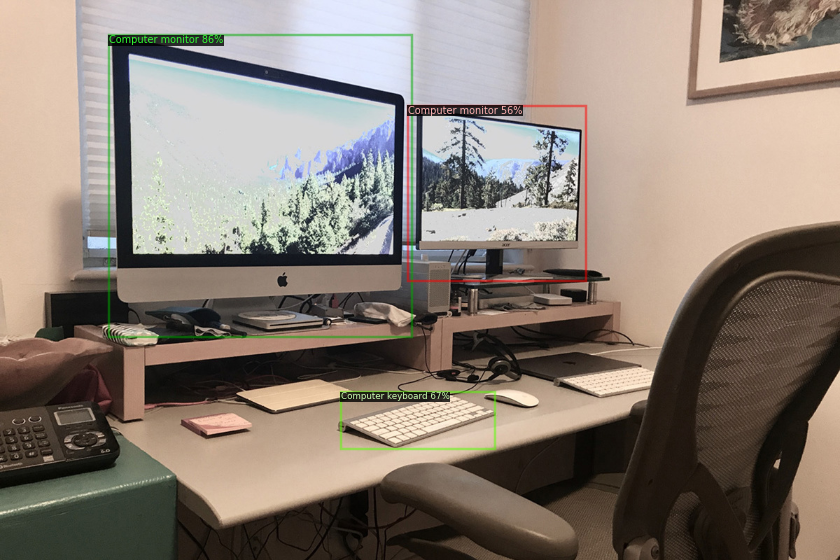

In [28]:
# Make a prediction with the custom model
make_inference("set.jpg",
               model_config="output/config.yaml",
               model_weights="output/model_final.pth",
               threshold=.5
          
              )